# Initial feature extraction
Purpose of the notebook:
- This notebook does some of the initial feature extraction, such as EEG delta power, heart rate mean and standard deviation, and plots their distributions per label

### feature calculation

In <a style='color:red'>red</a> are features explored in this notebook
* Calculate features:
  1. EEG features: 
    * to implement first (minimal list):
      * <a style="color:red"><b>Delta spectral power</b></a>
      * <a style="color:red"><b>Zero crossings</b></a>
      * <a style="color:red"><b>Abs total power</b></a>
      * <a style="color:red"><b>Relative Power in Main Frequency Bands** (for EEG and EOG only):</b></a> Assessing power distribution across standard EEG frequency bands.
      * Aperiodicity of delta power: How much delta power is changing over time
   * Potential additional features:
      * **Standard Deviation:** Measuring the variation in the EEG signal.
      * **Interquartile Range:** Highlighting the spread of the EEG data.
      * **Skewness and Kurtosis:** Assessing the asymmetry and tailedness of the EEG signal distribution.
      * **Hjorth Mobility and Complexity:** Calculating the frequency and complexity of the signal.
      * **Permutation Entropy:** Estimating the complexity of the signal.
      * **Higuchi and Petrosian Fractal Dimension:** Analyzing the fractal characteristics of the EEG signal.
  2. Heart rate (calculated from ECG) features: 
    * to implement first (minimal list):
      * <a style="color:red"><b>Mean:</b></a> mean HR across epoch
      * <a style="color:red"><b>Standard deviation:</b></a> SD of HR across epoch
      * **VLF Power (0-0.001 Hz HR variability)**: Very low frequency (0-0.001 Hz) power
      * **SD of VLF Power:** SD of VLF power across epoch
    * Potential additional features:
      * Time-Domain Features:
        * **RR Intervals and their Variations:** The basic measure of HRV, representing the time intervals between successive heartbeats.
        * **SDNN (Standard Deviation of NN Intervals):** Measures the variability in heart rate.
        * **RMSSD (Root Mean Square of the Successive Differences):** Reflects the short-term components of HRV, particularly influenced by parasympathetic activity.
        * **NN50 and pNN50:** NN50 counts the number of pairs of successive NN intervals that differ by more than 50 ms, and pNN50 is the proportion of NN50 divided by the total number of NN intervals.
      * Frequency-Domain Features:
        * **Power in Different Frequency Bands:** Typically, the power in the Low Frequency (LF, 0.04–0.15 Hz) and High Frequency (HF, 0.15–0.4 Hz) bands are used. LF reflects both sympathetic and parasympathetic activity, while HF is associated with parasympathetic activity.
        * **LF/HF Ratio:** Represents the balance between sympathetic and parasympathetic activity.
      * Nonlinear Features:
        * **Sample Entropy:** Measures the complexity or irregularity of the RR interval time series.
        * **Poincaré Plot Parameters:** Such as SD1 (standard deviation of points perpendicular to the line of identity) and SD2 (standard deviation of points along the line of identity), reflecting short-term and long-term HRV respectively.
      * Geometrical Features:
        * **HRV Triangular Index:** Measures the total number of all NN intervals divided by the height of the histogram of all NN intervals.
        * **TINN (Triangular Interpolation of NN Interval Histogram):** Reflects the baseline width of the RR interval distribution.
      * Statistical and Miscellaneous Features:
        * **Skewness and Kurtosis of RR Intervals:** Indicating the asymmetry and tailedness of the RR interval distribution.
        * **Mean/SD Heart Rate:** Average rate of heartbeats per minute.

# [Data loading](#data_loading)
# [Feature extraction](#feature_extraction)
- ## [EEG Features](#feature_eeg)
- ## [ECG Features](#feature_ecg)

### [Frequency Band Exploration](#freq_bands)

In [2]:
import mne
import os
import sys
import pytz
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
%load_ext autoreload
%autoreload 2

In [16]:
# Add the src directory to the path
sys.path.insert(0, '..')
from src.features.feature_generation_utils import *
from src.visualization.visualize import plot_feature_density

<a id='data_loading'></a>

---
# Load in data

---

### Navigate to data folder

In [5]:
# Construct the relative path to the folder containing processed data
data_folder_path = os.path.abspath(os.path.join('..', 'data', 'raw'))
process_data_path = os.path.abspath(os.path.join(data_folder_path, '01_edf_data'))
print(process_data_path)

/Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/data/raw/01_edf_data


### Read in header information

In [6]:
# Read the header information to identify channels and their sampling frequencies
info = mne.io.read_raw_edf(f'{process_data_path}/test12_Wednesday_05_ALL_PROCESSED.edf',
                           preload=False).info

# Print the channel information
print(info)

# Identify channels and their corresponding sampling frequencies
channels_info = info['chs']
sampling_freq_map = {}

Extracting EDF parameters from /Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/data/raw/01_edf_data/test12_Wednesday_05_ALL_PROCESSED.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 8 non-empty values
 bads: []
 ch_names: ECG_Raw_Ch1, ECG_ICA2, LEOG_Pruned_Ch2, LEMG_Pruned_Ch4, ...
 chs: 16 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2019-10-25 08:21:02 UTC
 nchan: 16
 projs: []
 sfreq: 500.0 Hz
 subject_info: 1 item (dict)
>


#### Load in raw data for just day one of the data

In [7]:
# Load the EDF file, excluding the EOGs and EKG channels
raw = mne.io.read_raw_edf(f'{process_data_path}/test12_Wednesday_05_DAY1_PROCESSED.edf', preload=True)
# raw.resample(100)                      # Downsample the data to 100 Hz
# raw.filter(0.1, 40)                    # Apply a bandpass filter from 0.1 to 40 Hz
# raw.pick_channels(['C4-A1', 'C3-A2'])  # Select a subset of EEG channels
raw # Outputs summary data about file

# Inspect Data
print(raw.info)
print('The channels are:', raw.ch_names)
print('The sampling frequency is:', raw.info['sfreq'])

# Rename channels (replace spaces if any)
channel_renaming_dict = {name: name.replace(' ', '_') for name in raw.ch_names}
raw.rename_channels(channel_renaming_dict)
print('The channels are:', raw.ch_names)

# ['ECG_Raw_Ch1', 'ECG_ICA2', 'LEOG_Pruned_Ch2', 'LEMG_Pruned_Ch4', 'REEG2_Pruned_Ch7', 'LEEG3_Pruned_Ch8', 
# 'REEG2_Raw_Ch7', 'LEEG3_Raw_Ch8', 'EEG_ICA5', 'pitch', 'roll', 'heading', 'GyrZ', 'MagZ', 'ODBA', 'Pressure']

# Assuming 'raw' is your Raw object from MNE
channel_types = {}

for ch in raw.ch_names:
    if ch.startswith('ECG'):
        channel_types[ch] = 'ecg'
    elif ch.startswith(('LEOG', 'REOG')):
        channel_types[ch] = 'eog'
    elif ch.startswith(('LEMG', 'REMG')):
        channel_types[ch] = 'emg'
    elif ch.startswith(('LEEG', 'REEG')):
        channel_types[ch] = 'eeg'
    elif ch in ['pitch', 'roll', 'heading']:
        channel_types[ch] = 'resp'
    elif ch in ['GyrZ', 'MagZ', 'ODBA']:
        channel_types[ch] = 'syst'
    elif ch in ['Pressure']:
        channel_types[ch] = 'misc'
    elif ch == 'Heart_Rate':
        channel_types[ch] = 'bio'

# Now set the channel types
raw.set_channel_types(channel_types)
print()

Extracting EDF parameters from /Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/data/raw/01_edf_data/test12_Wednesday_05_DAY1_PROCESSED.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43199999  =      0.000 ... 86399.998 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: ECG_Raw_Ch1, ECG_ICA2, LEOG_Pruned_Ch2, LEMG_Pruned_Ch4, ...
 chs: 16 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2019-10-25 08:21:02 UTC
 nchan: 16
 projs: []
 sfreq: 500.0 Hz
 subject_info: 1 item (dict)
>
The channels are: ['ECG_Raw_Ch1', 'ECG_ICA2', 'LEOG_Pruned_Ch2', 'LEMG_Pruned_Ch4', 'REEG2_Pruned_Ch7', 'LEEG3_Pruned_Ch8', 'REEG2_Raw_Ch7', 'LEEG3_Raw_Ch8', 'EEG_ICA5', 'pitch', 'roll', 'heading', 'GyrZ', 'MagZ', 'ODBA', 'Pressure']
The sampling frequency is: 500.0
The channels are: ['ECG_Raw_Ch1', 'ECG_ICA2', 'LEOG_Pruned_Ch2', 'LEMG_Pruned_Ch4', 'REEG2_Pruned_Ch7', 'LEEG3_Pruned_Ch8', 'REEG2_

/var/folders/by/vpz_wqc14_vgx3vzwgf90gw00000gn/T/ipykernel_55940/2530690281.py:43: RuntimeWarning: The unit for channel(s) GyrZ, MagZ, ODBA, Pressure has changed from V to NA.
  raw.set_channel_types(channel_types)


#### Get metadata from file

Get start time, channel names, etc.

In [8]:
channels = ['ECG_Raw_Ch1', 'ECG_ICA2', 'LEOG_Pruned_Ch2', 'LEMG_Pruned_Ch4', 'REEG2_Pruned_Ch7',
            'LEEG3_Pruned_Ch8', 'REEG2_Raw_Ch7', 'LEEG3_Raw_Ch8', 'EEG_ICA5', 'pitch', 'roll',
            'heading', 'GyrZ', 'MagZ', 'ODBA', 'Pressure']
#     sns.kdeplot(raw.copy().pick([channel]).get_data()[0,:]).set_title(channel)
#     plt.show()

In [9]:
# Inspect Data
print(raw.info)
print('The channels are:', raw.ch_names)
print('The sampling frequency is:', raw.info['sfreq'])

# Extract the measurement date (start time) from raw.info
start_time = raw.info['meas_date']
fs = raw.info['sfreq']

# Define the PST timezone
pst_timezone = pytz.timezone('America/Los_Angeles')

# Convert to datetime object in PST
if isinstance(start_time, datetime.datetime):
    # If it's already a datetime object, just replace the timezone
    recording_start_datetime = start_time.replace(tzinfo=None).astimezone(pst_timezone)
elif isinstance(start_time, (int, float)):
    # Convert timestamp to datetime in PST
    recording_start_datetime = pst_timezone.localize(datetime.datetime.fromtimestamp(start_time))
else:
    # Handle other formats if necessary
    pass

# Calculate the recording duration in seconds
recording_duration_seconds = len(raw) / fs

# Calculate the recording end datetime
recording_end_datetime = recording_start_datetime + datetime.timedelta(seconds=recording_duration_seconds)

# Calculate duration as a timedelta object
duration_timedelta = datetime.timedelta(seconds=recording_duration_seconds)

# Create a time index
#time_index = pd.date_range(recoring_start_datetime, recording_end_datetime)

# Format duration into days, hours, minutes, and seconds
days = duration_timedelta.days
hours, remainder = divmod(duration_timedelta.seconds, 3600)
minutes, seconds = divmod(remainder, 60)

print('The start time in PST (Los Angeles) is:', recording_start_datetime)
print('The end time in PST (Los Angeles) is:', recording_end_datetime)
print(f'Duration: {days} days, {hours} hours, {minutes} minutes, {seconds} seconds')


<Info | 8 non-empty values
 bads: []
 ch_names: ECG_Raw_Ch1, ECG_ICA2, LEOG_Pruned_Ch2, LEMG_Pruned_Ch4, ...
 chs: 2 ECG, 1 EOG, 1 EMG, 5 EEG, 3 RESP, 3 SYST, 1 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2019-10-25 08:21:02 UTC
 nchan: 16
 projs: []
 sfreq: 500.0 Hz
 subject_info: 1 item (dict)
>
The channels are: ['ECG_Raw_Ch1', 'ECG_ICA2', 'LEOG_Pruned_Ch2', 'LEMG_Pruned_Ch4', 'REEG2_Pruned_Ch7', 'LEEG3_Pruned_Ch8', 'REEG2_Raw_Ch7', 'LEEG3_Raw_Ch8', 'EEG_ICA5', 'pitch', 'roll', 'heading', 'GyrZ', 'MagZ', 'ODBA', 'Pressure']
The sampling frequency is: 500.0
The start time in PST (Los Angeles) is: 2019-10-25 08:21:02-07:00
The end time in PST (Los Angeles) is: 2019-10-26 08:21:02-07:00
Duration: 1 days, 0 hours, 0 minutes, 0 seconds


<a id='feature_extraction'></a>

---
# Feature extraction
---

1. EEG features: 
* to implement first (minimal list):
  * Delta spectral power
  * Zero crossings
  * Abs total power
2. Heart rate (calculated from ECG) features: 
* to implement first (minimal list):
  * **Mean:** mean HR across epoch
  * **Standard deviation:** SD of HR across epoch
  * **VLF Power (0-0.001 Hz HR variability)**: Very low frequency (0-0.001 Hz) power
  * **SD of VLF Power:** SD of VLF power across epoch

<a id='feature_eeg'></a>
## EEG

### Delta spectral power

Good resource for spectral decomp:<br>
https://github.com/pennmem/PythonBootcamp/blob/master/Day%204%20-%20Spectral%20Decomp.ipynb<br>
How fourier transforms work:<br>
https://neuraldatascience.io/7-eeg/time_freq.html

In [10]:
# Load labeled data
# Path to CSV with scored data
file_path = '../data/raw/02_hypnogram_data/test12_Wednesday_06_Hypnogram_JKB_1Hz.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)
df['R.Time'] = pd.to_datetime(df['R.Time']).dt.tz_localize('America/Los_Angeles')
df['Sleep.Code'].value_counts(normalize=True)

Sleep.Code
Active Waking         0.456175
Quiet Waking          0.143221
HV Slow Wave Sleep    0.124564
Drowsiness            0.075781
Certain REM Sleep     0.072228
LV Slow Wave Sleep    0.071997
Putative REM Sleep    0.034134
Unscorable            0.021901
Name: proportion, dtype: float64

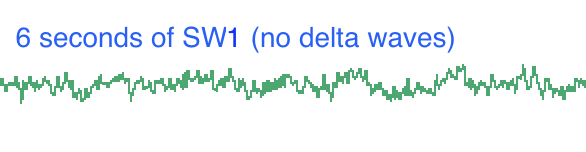

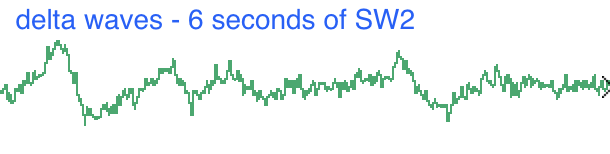

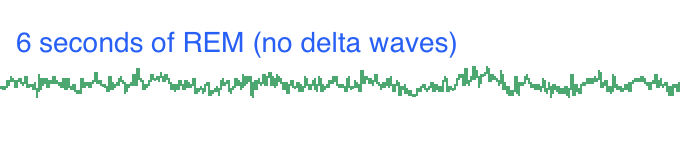

In [11]:
from IPython.display import Image 
from IPython.core.display import HTML 

img_path = '../reports/figures/labchart/' 
display(Image(filename = img_path + 'slow-wave-1.png', width=800, height=300))
display(Image(filename = img_path + 'slow-wave-2.png', width=800, height=300))
display(Image(filename = img_path + 'rem.png', width=800, height=300))


In [12]:
ecg_data = raw.copy().pick(['ECG_Raw_Ch1']).get_data()[0]
eeg_data = raw.copy().pick(['EEG_ICA5']).get_data()[0]
# If you loaded in the full Wednesday file and not just day 1:
# one_day = 500 * 60 * 60 * 24 # 500 data points per second, 60 sec/min, 60 min/hr, 24 hr/day
# ecg_data = raw.copy().pick(['ECG_ICA2']).get_data()[0, :one_day]
# eeg_data = raw.copy().pick(['EEG_ICA5']).get_data()[0, :one_day]

offset = (df['R.Time'].iloc[0] - recording_start_datetime).total_seconds()
ecg_data = ecg_data[int(offset*500):]
eeg_data = eeg_data[int(offset*500):]

In [13]:
duration_seconds = len(ecg_data) // 500

In [14]:
print(len(ecg_data), len(eeg_data), sep='\n')

31670000
31670000


In [14]:
label_colors = {
    "Certain REM Sleep": "#FCBE46",
    "Putative REM Sleep": "#FCBE46",
    "HV Slow Wave Sleep": "#41b6c4",
    "LV Slow Wave Sleep": "#c7e9b4",
    "Drowsiness": "#BBA9CF",
    "Quiet Waking": "#225ea8",
    "Active Waking": "#0c2c84",
    "Unscorable": "#D7D7D7"
}
label_colors['SWS'] = label_colors['HV Slow Wave Sleep']
label_colors['REM'] = label_colors['Certain REM Sleep']

delta
theta
alpha
sigma
beta


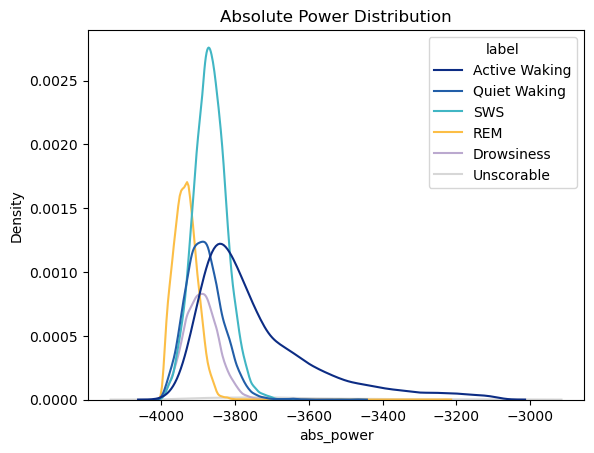

In [22]:
FREQ_BANDS = {
    "delta": (0.4, 4.0),
    "theta": (4.0, 8.5),
    "alpha": (8.5, 11.5),
    "sigma": (11.5, 15.5),
    "beta": (15.5, 30)
}
freq_band_names = list(FREQ_BANDS.keys())
freq_band_powers = {}
for freq_band in FREQ_BANDS.keys():
    print(freq_band)
    band_power = get_rolling_band_power_welch(eeg_data, 0, len(eeg_data), freq_range=FREQ_BANDS[freq_band],
                                              ref_power=1, freq=500, window_sec=2, step_size=1)
    freq_band_powers[freq_band] = band_power
    
# Absolute power
abs_power_dB = get_rolling_band_power_welch(eeg_data, 0, len(eeg_data), freq_range=(0.4, 30),
                                            ref_power=1, freq=500, window_sec=2, step_size=1)
abs_power_with_labels = pd.DataFrame({
    'abs_power': abs_power_dB,
    'label': df['Simple.Sleep.Code'].iloc[:duration_seconds]
}).dropna()
ax = plot_feature_density(abs_power_with_labels, 'abs_power', 'label',
                          title='Absolute Power Distribution', filter_val=0.01)
plt.show()

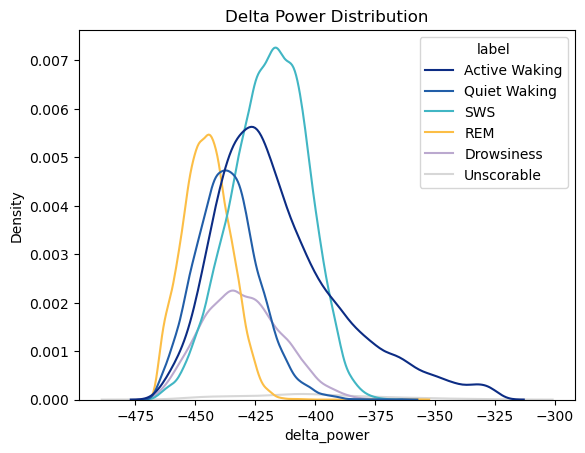

In [23]:
# Delta power
delta_power = freq_band_powers['delta']
delta_power_with_labels = pd.DataFrame({
    'delta_power': delta_power,
    'label': df['Simple.Sleep.Code'].iloc[:duration_seconds]
}).dropna()
ax = plot_feature_density(delta_power_with_labels, 'delta_power', 'label',
                          title='Delta Power Distribution', filter_val=0.01)
plt.show()

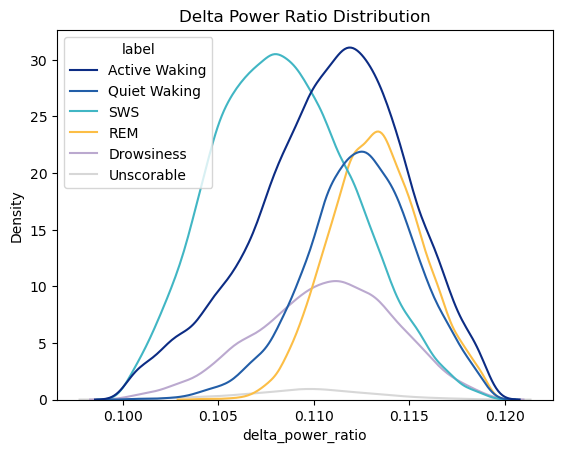

In [26]:
# Delta power ratio
delta_ratio = freq_band_powers['delta'] / abs_power_dB
delta_ratio_with_labels = pd.DataFrame({
    'delta_power_ratio': delta_ratio,
    'label': df['Simple.Sleep.Code'].iloc[:duration_seconds]
}).dropna()
ax = plot_feature_density(delta_ratio_with_labels, 'delta_power_ratio', 'label',
                          title='Delta Power Ratio Distribution', filter_val=0.01)
plt.show()

<b>note that these values are the log of the actual value, so a lower value means higher power</b>

### Zero crossings

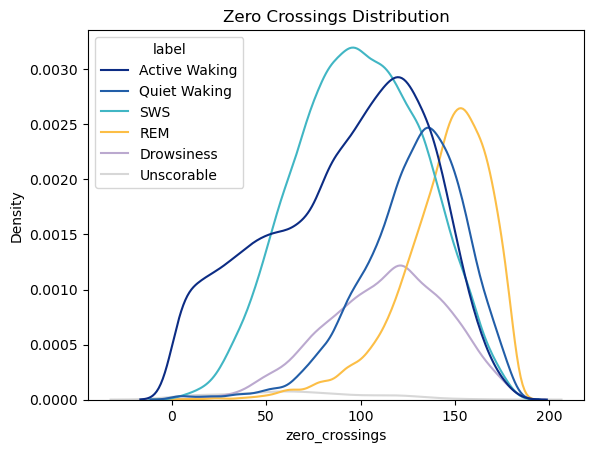

In [29]:
zero_crossings = get_rolling_zero_crossings(eeg_data, 0, len(eeg_data))
zero_crossings_with_labels = pd.DataFrame({
    'zero_crossings': zero_crossings,
    'label': df['Simple.Sleep.Code'].iloc[:duration_seconds]
}).dropna()
ax = plot_feature_density(zero_crossings_with_labels, 'zero_crossings', 'label',
                          title='Zero Crossings Distribution', filter_val=0.01)
plt.show()

<a id='feature_ecg'></a>

## Heart rate (from ECG)

In [27]:
hr_data = get_heart_rate(ecg_data)

/Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/notebooks/../src/features/feature_generation_utils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  heart_rates = [60 / ((rpeaks_corrected[i+1] - rpeaks_corrected[i]) / fs) for i in range(len(rpeaks_corrected) - 1)]


Filled: 0


### Rolling mean & standard deviation

In [28]:
# Heart rate 30-second mean and standard deviation
hr_mean, hr_std = get_rolling_mean_std(hr_data, 0, len(hr_data))

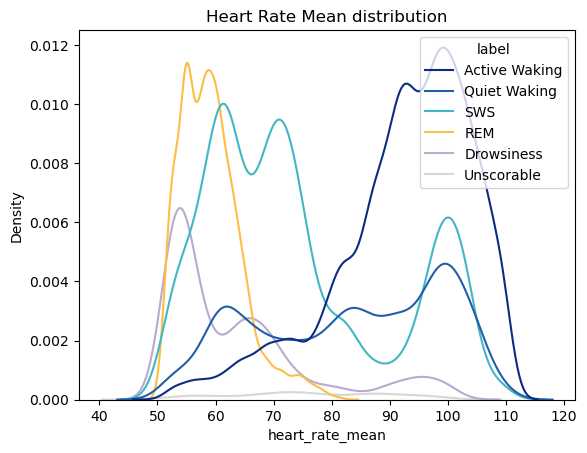

In [31]:
heart_rate_mean_with_labels = pd.DataFrame({
    'heart_rate_mean': hr_mean,
    'label': df['Simple.Sleep.Code'].iloc[:duration_seconds]
}).dropna()
ax = plot_feature_density(heart_rate_mean_with_labels, 'heart_rate_mean', 'label',
                          title='Heart Rate Mean distribution', filter_val=0.01)
plt.show()

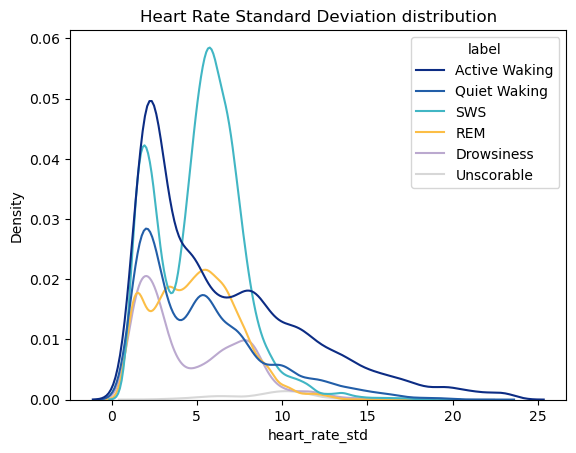

In [32]:
heart_rate_std_with_labels = pd.DataFrame({
    'heart_rate_std': hr_std,
    'label': df['Simple.Sleep.Code'].iloc[:duration_seconds]
}).dropna()
ax = plot_feature_density(heart_rate_std_with_labels, 'heart_rate_std', 'label',
                          title='Heart Rate Standard Deviation distribution', filter_val=0.01)
plt.show()